# [Goal Based Investing](https://en.wikipedia.org/wiki/Goal-based_investing)
### Maximizing value using quantum techniques

## Problem Description
Suppose we have $N$ goals $\{A, B, C...N \}$ and value $v(i)$ for each goal. We want to allocate our wealth and investments to maximize expected value delivered to us over our time horizon.
$$max \sum_{i=1}^{N} v(i)\phi(i)$$ 

where $\phi(i)$ is the probability of achieving goal $i$.

For this application, we will assume a normal distribution for portfolio returns, which is [an appropriate assumption for that use](https://www.investopedia.com/articles/investing/102014/lognormal-and-normal-distribution.asp).

We will obtain the probability from the cumulative distribution function (CDF):

$\phi(i) = 1 - \Phi(i)$ where $\Phi$ is the CDF for goal $i$.

While it computationally cheap to compute a probability from a CDF for a given value, it is hard to instead optimize the value, so we will approximate the CDF with a polynomial.

We can approximate the CDF very well with a z-score constrained between bounds below with the following cubic function:

$\Phi(z) = -0.0277939z^3 + 0.00387615z^2+0.356886z+0.49535$ where $z$ is the z-score for the wealth allocation.

Essentially, we are pulling and optimizing the following levers: wealth allocation toward each goal and portfolio allocation for each goal.

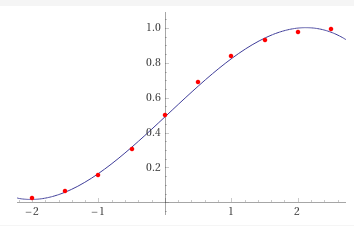

The z-score is computed in the following way: $z_i = \frac{F_i-W_i}{\sigma_i}$ where $W_i$ is the wealth needed to obtain the goal (the cost), $F_i$ is the expected wealth at the time of the goal given a current dollar amount allocated to the goal and expected returns, and $\sigma_i$ is the standard deviation of future wealth.

The expected future value of wealth allocated for the goal at the time of the goal is $F_i = a_{ij}(w_i \times (1+r_j)^n) +...$ where $a_{ij}$ is the binary variable indicating whether we allocate the wealth set aside for goal $i$ to portfolio $j$, $w_i$ is the amount of current (present day) wealth to allocate for goal $i$, $r_j$ is the expected annual return of portfolio $j$, and $n$ is the number of years until the goal. 

We can only allocate the wealth for the goal toward one portfolio. For each goal $i$, the sum of $a_{ij}$ must equal 1. We'll pick from portfolios on the efficient frontier.

$w_i$ is fractional amounts of $W_i$. In our implementation, $w_i$ is structured in the following way: $w_i = \frac{1}2 W_i \times x_{i1} + \frac{1}4 W_i \times x_{i2} + \frac{1}8 W_i \times x_{i3}$ +... . Each $x$ variable indicates whether or not we include its corresponding coefficient amount of wealth. So, for `fractional_precision = 5`, we could allocate wealth for a goal in increments of $\frac{1}{32}$ of the cost of the goal between $\frac{1}{32}$ and $\frac{31}{32}$ of the cost of the goal. We constrain that the sum of all $w_i$ must be less than or equal to the total wealth we have available.

In [1]:
from goal_investing_helper import * # Helper functions (not publically available)

In [2]:
import qubovert as qv
import sympy

current_wealth = 30

# Annualized expected returns and volatilities for different efficient portfolios
portfolios = {
    
    0 : {"exp_ret" : 5, "vol" : 3},
    1 : {"exp_ret" : 7, "vol" : 10},
    2 : {"exp_ret" : 9, "vol" : 20},
    3 : {"exp_ret" : 12, "vol" : 35},
}

fractional_precision = 5

# The value (utility), cost, and time in years until each goal
goals = {
    0 : {"value" : 3000, "cost" : 8, "time" : 7},
    1 : {"value" : 250, "cost" : 8, "time" : 10},
    2 : {"value" : 350, "cost" : 4, "time" : 15},
    3 : {"value" : 1000, "cost" : 8, "time" : 20},
    4 : {"value" : 500, "cost" : 7, "time" : 25},
    5 : {"value" : 400, "cost" : 18, "time" : 30},
    6 : {"value" : 1000, "cost" : 21, "time" : 35},
    7 : {"value" : 2000, "cost" : 23, "time" : 40},
    8 : {"value" : 3000, "cost" : 25, "time" : 45},
}


In [3]:
lam =sympy.Symbol("lam") # Placeholder for penalty term

obj, x, a = create_obj_function(goals, portfolios, fractional_precision, current_wealth)


print("Objective function constructed")


100%|██████████| 9/9 [00:19<00:00,  2.20s/it]


Objective function constructed


In [4]:
M = calculate_lam(obj, lam) / 2 # Subsitute penalty factor
obj = obj.subs({lam : M})

In [5]:
obj_qubo = obj.to_qubo()
len(obj_qubo.variables)

756

In [6]:
from qubovert.sim import anneal_qubo
from scipy.stats import norm
from pprint import pprint
%time res = anneal_qubo(obj_qubo, num_anneals=10000) # Solve the problem using simulated annealing

Wall time: 7min 15s


In [7]:
find_best_solution(obj, res, goals, portfolios, current_wealth) # Print the result from the results that maximizes expected value

100%|██████████| 10000/10000 [12:42<00:00, 13.12it/s]

---------------------------------------
Goal 0 allocated $5.25 to portfolio 2, which has expected return 9% and volatility 20% and has a value of 3000 cost of $8 in 7 years.
Expected future value: $9.6 
Standard deviation of future value: $0.93
Cost: $8 
Prob of meeting goal: 95.8% 
---------------------------------------
Goal 1 allocated $0.5 to portfolio 3, which has expected return 12% and volatility 35% and has a value of 250 cost of $8 in 10 years.
Expected future value: $1.55 
Standard deviation of future value: $3.63
Cost: $8 
Prob of meeting goal: 3.8% 
---------------------------------------
Goal 2 allocated $0.62 to portfolio 2, which has expected return 9% and volatility 20% and has a value of 350 cost of $4 in 15 years.
Expected future value: $2.28 
Standard deviation of future value: $3.02
Cost: $4 
Prob of meeting goal: 28.4% 
---------------------------------------
Goal 3 allocated $3.25 to portfolio 3, which has expected return 12% and volatility 35% and has a value of 

## Conclusion

The quantum technique delivers good results, achieving a high probability of success for valuable goals. For goals where it relatively little money is allocated, riskier portfolios tend to be chosen. This makes sense because a safer portfolio may not have a chance to reach the goal's cost in an "up" state.

The results could be improved with some classical post-processing. The quantum solution doesn't spend all available money, so we could allocate the last bits of money classically. Additionally, while the quantum solution rightfully prioritized allocating more money to more valuable goals, it over-allocated for some goals. This is likely due to the constraint to bound z-scores for our polynomial approximation of the normal distribution not being properly enforced, and it could be fixed with further work.